In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc
from scipy import sparse
from scipy.special import softmax

import networkx as nx
import torch

ROOT = Path('../')
sys.path.append(str(ROOT))
import came
from came import pipeline, pp, pl

Using backend: pytorch


In [2]:
from CAME.utils import load_example_data

example_data_dict = load_example_data()
print(example_data_dict.keys())

dsnames = ('Baron_human', 'Baron_mouse')

adatas = example_data_dict['adatas']
dsnames = example_data_dict['dataset_names']
df_varmap = example_data_dict['varmap']
df_varmap_1v1 = example_data_dict['varmap_1v1']

key_class1 = key_class2 = example_data_dict['key_class']

# setting directory for results
time_tag = came.make_nowtime_tag()
resdir = ROOT /'_temp' / f'{dsnames}-{time_tag}'
figdir = resdir / 'figs'
came.check_dirs(figdir)

dict_keys(['adatas', 'varmap', 'varmap_1v1', 'dataset_names', 'key_class'])
a new directory made:
	..\_temp\('Baron_human', 'Baron_mouse')-(07-12 01.17.28)\figs


In [4]:
# ========= customize paths ==========

tiss, (sp1, sp2) = 'brain', ('human', 'mouse')
dsnames = ('Lake_2018', 'Tasic18')
dsn1, dsn2 = dsnames

dir_gmap = Path('E:/lxy_pro/004/resources/mart_exports/exported_gene_matches')
datadir = Path('E:/lxy_pro/004/datasets') / 'formal' / tiss

df_varmap_1v1 = pd.read_csv(dir_gmap / f'gene_matches_1v1_{sp1}2{sp2}.csv', )
df_varmap = pd.read_csv(dir_gmap / f'gene_matches_{sp1}2{sp2}.csv', )
# df_varmap_1v1 = pd.read_csv(datadir / f'gene_matches_1v1_{sp1}2{sp2}.csv', )
# df_varmap = pd.read_csv(datadir / f'gene_matches_{sp1}2{sp2}.csv', )

dsn1, dsn2 = dsnames
adata_raw1 = sc.read_h5ad(datadir / f'raw-{dsn1}.h5ad')
adata_raw2 = sc.read_h5ad(datadir / f'raw-{dsn2}.h5ad')
adatas = [adata_raw1, adata_raw2]

key_class1 = 'cell_ontology_class'
key_class2 = 'cell_ontology_class'

# setting directory for results
time_tag = came.make_nowtime_tag()
resdir = ROOT /'_temp' / f'{dsnames}-{time_tag}'


In [10]:
figdir = resdir / 'figs'
came.check_dirs(figdir)

already exists:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\figs


In [5]:
# ====== subsampling and filtering genes (optional) =====
for _adt, _name in zip([adata_raw1, adata_raw2], dsnames):
    if _adt.shape[0] >= 2e4:
        print(f'Doing subsampling for {_name}')
        sc.pp.subsample(_adt, fraction=0.5)

sc.pp.filter_genes(adata_raw1, min_cells=3)
sc.pp.filter_genes(adata_raw2, min_cells=3)

Doing subsampling for Lake_2018
Doing subsampling for Tasic18


In [6]:
''' default pipeline of CAME
'''
n_epochs = 350
batch_size = None

came_inputs, (adata1, adata2) = pipeline.preprocess_unaligned(
    adatas,
    key_class=key_class1,
    use_scnets=True,
)

dpair, trainer, h_dict, predictor, ENV_VARs = pipeline.main_for_unaligned(
    **came_inputs,
    df_varmap=df_varmap,
    df_varmap_1v1=df_varmap_1v1,
    dataset_names=dsnames,
    key_class1=key_class1,
    key_class2=key_class2,
    do_normalize=True,
    n_epochs=n_epochs,
    resdir=resdir,
    n_pass=100,
    params_model=dict(residual=False),
    batch_size=batch_size,
)

obs_ids1, obs_ids2 = dpair.obs_ids1, dpair.obs_ids2
obs = dpair.obs
classes = predictor.classes


[leiden] Time used:  2.2419 s
computing differentially expressed genes using t-test
computing differential expression analysis using default settings,
 (assume that the expressioin values are already normalized)
groups to be removed:
	 []
500 genes before taking unique
taking total of 429 unique differential expressed genes
computing differentially expressed genes using t-test
computing differential expression analysis using default settings,
 (assume that the expressioin values are already normalized)
groups to be removed:
	 []
1000 genes before taking unique
taking total of 661 unique differential expressed genes
a new directory made:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\figs
already exists:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)
[NOTE]
the node features will be extracted from `adata.raw`, please make sure that the values are normalized.

[*] Setting dataset names:
	0-->Lake_2018
	1-->Tasic18
[*] Setting aligned features for observation nodes (self._featur

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch 0000 | Train Acc: 0.0130 | Test Acc or AMI: 0.0085 (max=0.0085) | AMI=0.0002 | Time: 0.7156
Epoch 0001 | Train Acc: 0.2017 | Test Acc or AMI: 0.0029 (max=0.0085) | AMI=0.0844 | Time: 0.4979
Epoch 0002 | Train Acc: 0.2204 | Test Acc or AMI: 0.4314 (max=0.4314) | AMI=0.1275 | Time: 0.4227
Epoch 0003 | Train Acc: 0.5207 | Test Acc or AMI: 0.5281 (max=0.5281) | AMI=0.1548 | Time: 0.3871
Epoch 0004 | Train Acc: 0.5091 | Test Acc or AMI: 0.5082 (max=0.5281) | AMI=0.1492 | Time: 0.3641
Epoch 0005 | Train Acc: 0.4807 | Test Acc or AMI: 0.5070 (max=0.5281) | AMI=0.1216 | Time: 0.3530
Epoch 0006 | Train Acc: 0.4866 | Test Acc or AMI: 0.5308 (max=0.5308) | AMI=0.1352 | Time: 0.3436
Epoch 0007 | Train Acc: 0.5197 | Test Acc or AMI: 0.5308 (max=0.5308) | AMI=0.1466 | Time: 0.3350
Epoch 0008 | Train Acc: 0.5559 | Test Acc or AMI: 0.5294 (max=0.5308) | AMI=0.1533 | Time: 0.3279
Epoch 0009 | Train Acc: 0.5822 | Test Acc or AMI: 0.5289 (max=0.5308) | AMI=0.1550 | Time: 0.3230
Epoch 0010 | Train A

Epoch 0084 | Train Acc: 0.9455 | Test Acc or AMI: 0.9788 (max=0.9798) | AMI=0.5185 | Time: 0.2905
Epoch 0085 | Train Acc: 0.9467 | Test Acc or AMI: 0.9780 (max=0.9798) | AMI=0.5185 | Time: 0.2906
Epoch 0086 | Train Acc: 0.9434 | Test Acc or AMI: 0.9773 (max=0.9798) | AMI=0.5182 | Time: 0.2906
Epoch 0087 | Train Acc: 0.9457 | Test Acc or AMI: 0.9780 (max=0.9798) | AMI=0.5184 | Time: 0.2904
Epoch 0088 | Train Acc: 0.9485 | Test Acc or AMI: 0.9777 (max=0.9798) | AMI=0.5182 | Time: 0.2904
Epoch 0089 | Train Acc: 0.9478 | Test Acc or AMI: 0.9785 (max=0.9798) | AMI=0.5184 | Time: 0.2902
Epoch 0090 | Train Acc: 0.9454 | Test Acc or AMI: 0.9768 (max=0.9798) | AMI=0.5157 | Time: 0.2901
Epoch 0091 | Train Acc: 0.9470 | Test Acc or AMI: 0.9777 (max=0.9798) | AMI=0.5191 | Time: 0.2905
Epoch 0092 | Train Acc: 0.9410 | Test Acc or AMI: 0.9765 (max=0.9798) | AMI=0.5174 | Time: 0.2907
Epoch 0093 | Train Acc: 0.9484 | Test Acc or AMI: 0.9796 (max=0.9798) | AMI=0.5206 | Time: 0.2907
Epoch 0094 | Train A

Epoch 0166 | Train Acc: 0.9694 | Test Acc or AMI: 0.9742 (max=0.9806) | AMI=0.5199 | Time: 0.2886
Epoch 0167 | Train Acc: 0.9657 | Test Acc or AMI: 0.9769 (max=0.9806) | AMI=0.5178 | Time: 0.2886
Epoch 0168 | Train Acc: 0.9697 | Test Acc or AMI: 0.9747 (max=0.9806) | AMI=0.5183 | Time: 0.2886
Epoch 0169 | Train Acc: 0.9661 | Test Acc or AMI: 0.9726 (max=0.9806) | AMI=0.5187 | Time: 0.2886
[current best] model weights backup
Epoch 0170 | Train Acc: 0.9676 | Test Acc or AMI: 0.9654 (max=0.9806) | AMI=0.5215 | Time: 0.2888
[current best] model weights backup
Epoch 0171 | Train Acc: 0.9678 | Test Acc or AMI: 0.9690 (max=0.9806) | AMI=0.5217 | Time: 0.2888
model weights backup
Epoch 0172 | Train Acc: 0.9711 | Test Acc or AMI: 0.9753 (max=0.9806) | AMI=0.5176 | Time: 0.2889
Epoch 0173 | Train Acc: 0.9629 | Test Acc or AMI: 0.9590 (max=0.9806) | AMI=0.5086 | Time: 0.2889
[current best] model weights backup
Epoch 0174 | Train Acc: 0.9698 | Test Acc or AMI: 0.9772 (max=0.9806) | AMI=0.5218 | Ti

Epoch 0246 | Train Acc: 0.9854 | Test Acc or AMI: 0.9755 (max=0.9806) | AMI=0.5230 | Time: 0.2884
Epoch 0247 | Train Acc: 0.9844 | Test Acc or AMI: 0.9768 (max=0.9806) | AMI=0.5203 | Time: 0.2883
Epoch 0248 | Train Acc: 0.9852 | Test Acc or AMI: 0.9784 (max=0.9806) | AMI=0.5232 | Time: 0.2883
Epoch 0249 | Train Acc: 0.9840 | Test Acc or AMI: 0.9752 (max=0.9806) | AMI=0.5211 | Time: 0.2883
Epoch 0250 | Train Acc: 0.9849 | Test Acc or AMI: 0.9769 (max=0.9806) | AMI=0.5205 | Time: 0.2882
Epoch 0251 | Train Acc: 0.9866 | Test Acc or AMI: 0.9784 (max=0.9806) | AMI=0.5217 | Time: 0.2882
Epoch 0252 | Train Acc: 0.9862 | Test Acc or AMI: 0.9788 (max=0.9806) | AMI=0.5222 | Time: 0.2882
Epoch 0253 | Train Acc: 0.9823 | Test Acc or AMI: 0.9733 (max=0.9806) | AMI=0.5255 | Time: 0.2882
Epoch 0254 | Train Acc: 0.9858 | Test Acc or AMI: 0.9742 (max=0.9806) | AMI=0.5250 | Time: 0.2882
Epoch 0255 | Train Acc: 0.9829 | Test Acc or AMI: 0.9777 (max=0.9806) | AMI=0.5194 | Time: 0.2882
[current best] model

Epoch 0329 | Train Acc: 0.9904 | Test Acc or AMI: 0.9799 (max=0.9806) | AMI=0.5208 | Time: 0.2893
Epoch 0330 | Train Acc: 0.9908 | Test Acc or AMI: 0.9787 (max=0.9806) | AMI=0.5215 | Time: 0.2893
Epoch 0331 | Train Acc: 0.9911 | Test Acc or AMI: 0.9751 (max=0.9806) | AMI=0.5179 | Time: 0.2893
Epoch 0332 | Train Acc: 0.9914 | Test Acc or AMI: 0.9753 (max=0.9806) | AMI=0.5219 | Time: 0.2893
Epoch 0333 | Train Acc: 0.9906 | Test Acc or AMI: 0.9779 (max=0.9806) | AMI=0.5220 | Time: 0.2892
Epoch 0334 | Train Acc: 0.9903 | Test Acc or AMI: 0.9802 (max=0.9806) | AMI=0.5218 | Time: 0.2892
Epoch 0335 | Train Acc: 0.9910 | Test Acc or AMI: 0.9769 (max=0.9806) | AMI=0.5221 | Time: 0.2892
Epoch 0336 | Train Acc: 0.9916 | Test Acc or AMI: 0.9748 (max=0.9806) | AMI=0.5194 | Time: 0.2892
Epoch 0337 | Train Acc: 0.9920 | Test Acc or AMI: 0.9768 (max=0.9806) | AMI=0.5194 | Time: 0.2891
Epoch 0338 | Train Acc: 0.9924 | Test Acc or AMI: 0.9799 (max=0.9806) | AMI=0.5186 | Time: 0.2891
Epoch 0339 | Train A

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


astrocyte                          1565
inhibitory neuron                  8263
excitatory neuron                 12935
microglial cell                     376
oligodendrocyte                    2234
cerebellar granule cell            1676
oligodendrocyte precursor cell      669
endothelial cell                    199
Purkinje cell                       491
brain pericyte                      123
unknown                             169
dtype: int64


object saved into:
	 ..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\datapair_init.pickle
Re-order the rows
figure has been saved into:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\figs\contingency_matrix(acc97.4%).png
figure has been saved into:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\figs\contingency_matrix-train.png
figure has been saved into:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\figs\heatmap_probas.pdf


In [ ]:
''' trainer '''
%matplotlib inline
trainer.plot_class_accs()
trainer.plot_cluster_index()

# trainer.plot_class_accs(fp=figdir / 'clf_acc.pdf')
trainer.plot_class_accs(fp=figdir / 'clf_acc.svg')
trainer.plot_cluster_index(fp=figdir / 'cluster_index_.svg')
# trainer.plot_cluster_index(fp=figdir / 'cluster_index_.svg')

In [ ]:
load_other_ckpt = False
if load_other_ckpt:
    obs, df_probs, h_dict, predictor = pipeline.gather_came_results(
            dpair,
            trainer,
            classes=ENV_VARs['classes'],
            keys=(key_class1, key_class2),
            keys_compare=(key_class1, key_class2),
            resdir=resdir,
            checkpoint='last',
            batch_size=None,
    )

figure has been saved into:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\figs\contingency_mat.png


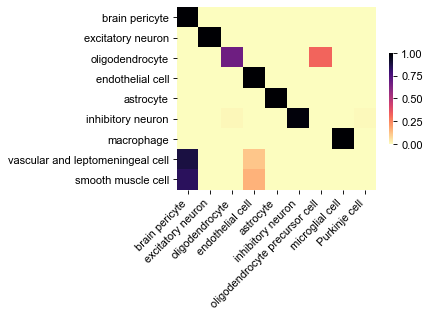

In [11]:
# contingency matrix for query dataset
y_true = obs['celltype'][obs_ids2].values
y_pred = obs['predicted'][obs_ids2].values
ax, contmat = pl.plot_contingency_mat(
    y_true, y_pred, norm_axis=1, 
    order_rows=False, order_cols=False,
)
pl._save_with_adjust(ax.figure, figdir / 'contingency_mat.png')
ax.figure

In [13]:
# ============== heatmap of predicted probabilities ==============
name_label = 'celltype'
cols_anno = ['celltype', 'predicted'][:]
df_probs = obs[list(classes)]

# probas_all = CAME.as_probabilities(
#     trainer.eval_current()['cell'], 
#     mode='sigmoid')
# df_probs = pd.DataFrame(probas_all, columns=classes)


# df_lbs = obs[cols_anno][obs[key_class1] == 'unknown'].sort_values(cols_anno)
df_lbs = obs[cols_anno].iloc[obs_ids2].sort_values(cols_anno)

indices = came.subsample_each_group(df_lbs['celltype'], n_out=50, )
# indices = df_lbs.index
df_data = df_probs.loc[indices, :].copy()
df_data = df_data[sorted(df_lbs['predicted'].unique())]  # .T
lbs = df_lbs[name_label][indices]

_ = pl.heatmap_probas(
    df_data.T, lbs, name_label='true label',
    figsize=(5, 3.), fp=figdir / f'heatmap_probas.pdf'
)


figure has been saved into:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\figs\heatmap_probas.pdf


In [ ]:
# In[]
# ============== heatmap of predicted probabilities (loop test) ==============
name_label = 'celltype'
cols_anno = ['celltype', 'predicted'][:]

out_cell = trainer.eval_current()['cell']
probas_all = CAME.as_probabilities(out_cell, mode='sigmoid')
df_probs = pd.DataFrame(probas_all, columns=classes)

for i, _obs_ids in enumerate([obs_ids1, obs_ids2]):
    # df_lbs = obs[cols_anno][obs[key_class1] == 'unknown'].sort_values(cols_anno)
    df_lbs = obs[cols_anno].iloc[_obs_ids].sort_values(cols_anno)
    
    indices = CAME.subsample_each_group(df_lbs['celltype'], n_out=50, )
    # indices = df_lbs.index
    df_data = df_probs.loc[indices, :].copy()
    df_data = df_data[sorted(df_lbs['predicted'].unique())]  # .T
    lbs = df_lbs[name_label][indices]
    
    _ = pl.heatmap_probas(
        df_data.T, lbs, name_label='true label', 
        cmap_heat='RdBu_r',
        figsize=(5, 3.), fp=figdir / f'heatmap_probas-{i}.pdf'
    )

In [30]:
# In[]
''' ======================= further analysis =======================
--> make adata on hidden states
'''

h_dict = trainer.model.get_hidden_states(
    trainer.feat_dict, trainer.g, detach2np=True)
# h_dict = trainer.model.get_hidden_states()

adt = pp.make_adata(h_dict['cell'], obs=dpair.obs, assparse=False, ignore_index=True)
gadt = pp.make_adata(h_dict['gene'], obs=dpair.var.iloc[:, :2], assparse=False, ignore_index=True)

adt.write(resdir / 'adt_hidden_cell.h5ad')
gadt.write_h5ad(resdir / 'adt_hidden_gene.h5ad')
# category-bool in gadt.obs will raise error by scanpy


C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")
... storing 'dataset' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'celltype' as categorical
... storing 'predicted' as categorical


adding columns to `adata.obs` (ignore_index=True):
original_name, dataset, cell_ontology_class, celltype, predicted, max_probs, is_right, astrocyte, inhibitory neuron, excitatory neuron, microglial cell, oligodendrocyte, cerebellar granule cell, oligodendrocyte precursor cell, endothelial cell, Purkinje cell, brain pericyte, done!
adding columns to `adata.obs` (ignore_index=True):
name, dataset, done!


... storing 'name' as categorical
... storing 'dataset' as categorical


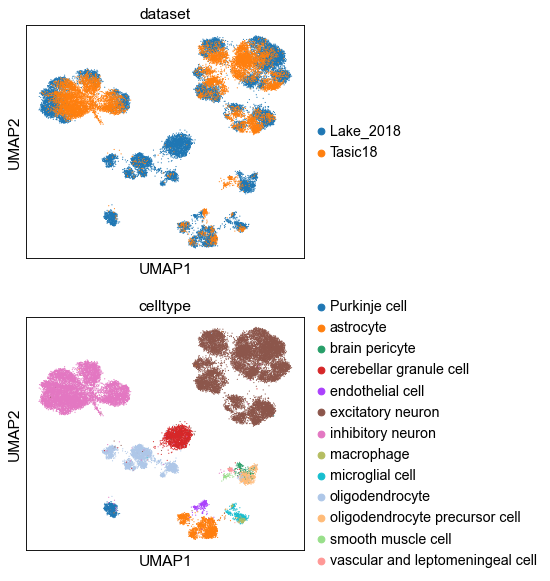

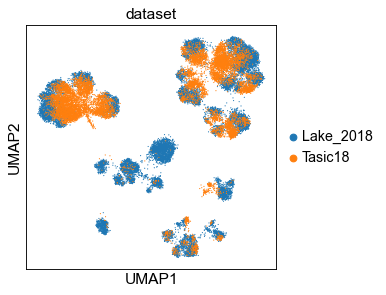

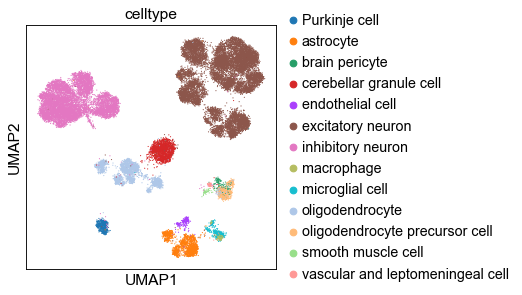

In [31]:
# In[]
'''======================= cell embeddings ======================='''
# from CAME_v0.utils.plot_pub import plot_pure_umap

sc.set_figure_params(dpi_save=200)

sc.pp.neighbors(adt, n_neighbors=15, metric='cosine', use_rep='X')
sc.tl.umap(adt)
sc.pl.umap(adt, color=['dataset', 'celltype'], ncols=1)
# setting UMAP to the original adata
obs_umap = adt.obsm['X_umap']
adata1.obsm['X_umap'] = obs_umap[obs_ids1]
adata2.obsm['X_umap'] = obs_umap[obs_ids2]

ftype = ['.svg', ''][1]
sc.pl.umap(adt, color='dataset', save=f'-dataset{ftype}')
sc.pl.umap(adt, color='celltype', save=f'-ctype{ftype}')

adt.write(resdir / 'adt_hidden_cell.h5ad')



In [32]:
adt.obs_names = adt.obs_names.astype(str)

In [33]:
# In[]
''' similaraties of cell-type embeddings
'''
dsn1, dsn2 = dsnames
adt.obs_names
adt1, adt2 = pp.bisplit_adata(adt, 'dataset', dsn1, reset_index_by='original_name')
avg_embed1 = pp.group_mean_adata(adt1, 'celltype')
avg_embed2 = pp.group_mean_adata(adt2, 'celltype')

from scipy.spatial.distance import cdist
dist = cdist(avg_embed1.values.T, avg_embed2.values.T, metric='cosine')
sim = pd.DataFrame(
        data=1 - dist,
        index=avg_embed1.columns, columns=avg_embed2.columns
        )           
ax = pl.heatmap(sim, order_col=True, order_row=True, figsize=(5, 4), 
                fp=resdir / 'celltype_embed_sim.png')
ax.figure.show()


Computing averages grouped by celltype
Computing averages grouped by celltype
Re-order the columns
Re-order the rows
figure has been saved into:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\celltype_embed_sim.png


<ipython-input-33-c2a62aa0aa1f>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


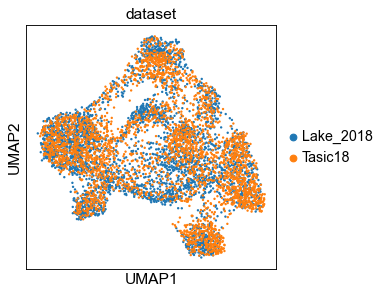

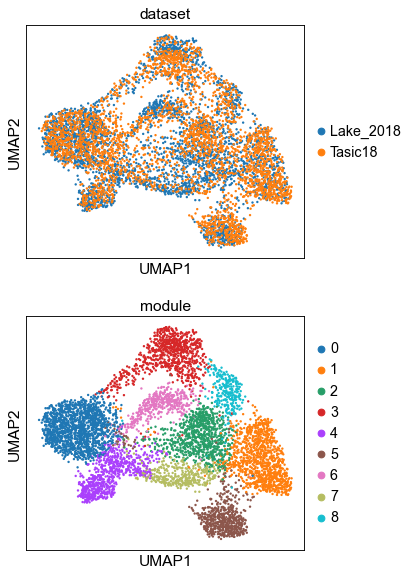

sorting links by weights


C:\Users\Administrator\anaconda3\lib\site-packages\anndata\_core\anndata.py:868: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['CTB-129O4.1', 'RP11-53O19.2', 'RN7SL787P', 'RD3', 'MAL2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")
C:\Users\Administrator\anaconda3\lib\site-packages\anndata\_core\anndata.py:868: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['Mpz', 'A330049N07Rik', 'Tekt4', 'Slc6a3', 'Higd1b']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


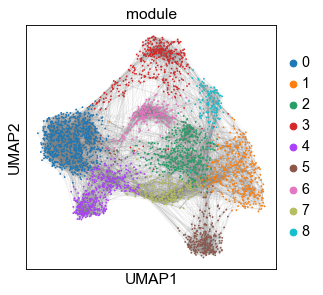

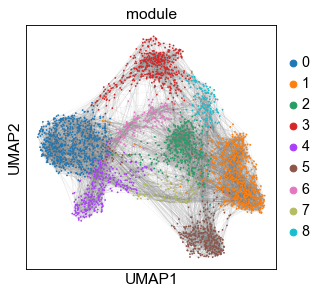

In [35]:
# In[]
'''===================== gene embeddings ====================='''
sc.set_figure_params(dpi_save=200)

sc.pp.neighbors(gadt, n_neighbors=15, metric='cosine', use_rep='X')
sc.tl.umap(gadt)
sc.pl.umap(gadt, color='dataset', )

''' joint gene module extraction '''
sc.tl.leiden(gadt, resolution=.8, key_added='module')
sc.pl.umap(gadt, color=['dataset', 'module'], ncols=1)

''' link-weights between homologous gene pairs '''
df_var_links = came.weight_linked_vars(
    gadt.X, dpair._vv_adj, names=dpair.get_vnode_names(),
    matric='cosine', index_names=dsnames,
)

# split
gadt.obs_names = gadt.obs_names.astype(str)
gadt1, gadt2 = pp.bisplit_adata(gadt, 'dataset', dsn1, reset_index_by='name')

color_by = 'module'
sc.pl.umap(gadt1, color=color_by, s=10, edges=True, edges_width=0.05,
           save=f'_{color_by}-{dsn1}')
sc.pl.umap(gadt2, color=color_by, s=10, edges=True, edges_width=0.05,
           save=f'_{color_by}-{dsn2}')



In [ ]:
# In[]
''' gene 3d map
'''



Computing averages grouped by cell_ontology_class
Calculating feature averages for 10 groups
['Purkinje cell' 'astrocyte' 'brain pericyte' 'cerebellar granule cell'
 'endothelial cell' 'excitatory neuron' 'inhibitory neuron'
 'microglial cell' 'oligodendrocyte' 'oligodendrocyte precursor cell']
Computing averages grouped by cell_ontology_class
Calculating feature averages for 9 groups
['astrocyte' 'brain pericyte' 'endothelial cell' 'excitatory neuron'
 'inhibitory neuron' 'macrophage' 'oligodendrocyte' 'smooth muscle cell'
 'vascular and leptomeningeal cell']
adding columns to `adata.obs` (ignore_index=True):
Purkinje cell, astrocyte, brain pericyte, cerebellar granule cell, endothelial cell, excitatory neuron, inhibitory neuron, microglial cell, oligodendrocyte, oligodendrocyte precursor cell, done!
adding columns to `adata.obs` (ignore_index=True):
astrocyte, brain pericyte, endothelial cell, excitatory neuron, inhibitory neuron, macrophage, oligodendrocyte, smooth muscle cell, vasc

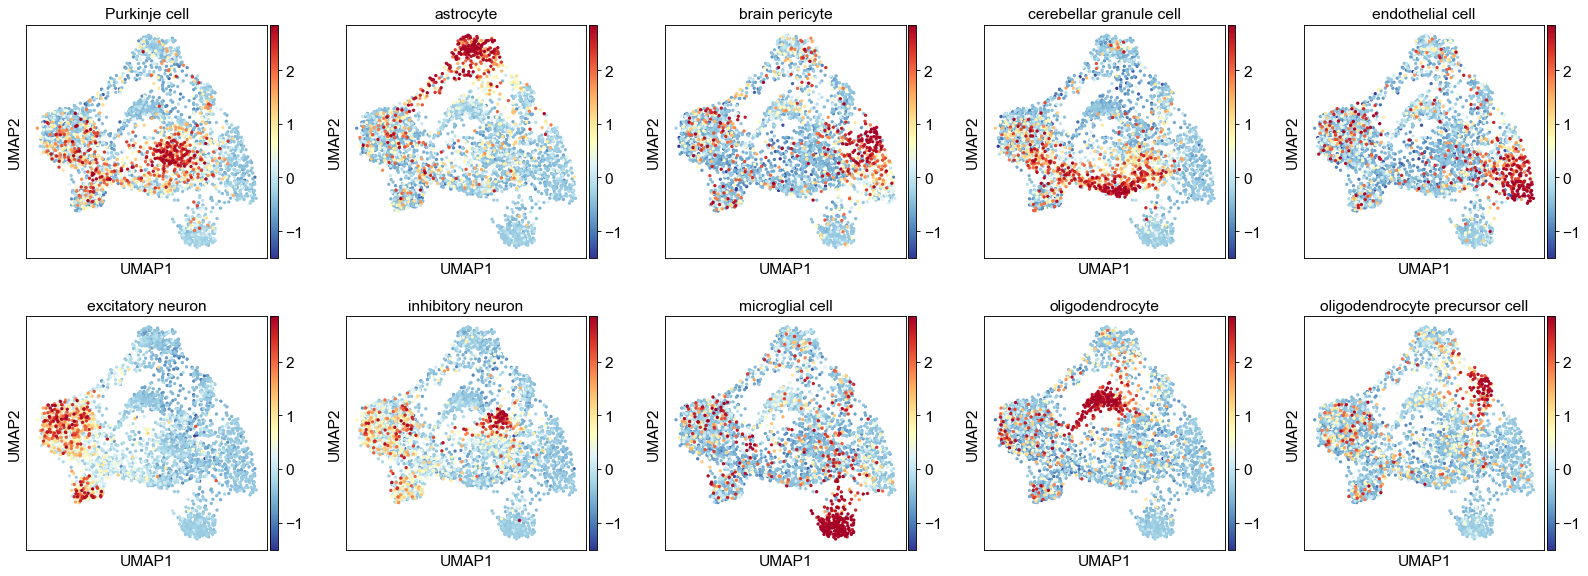

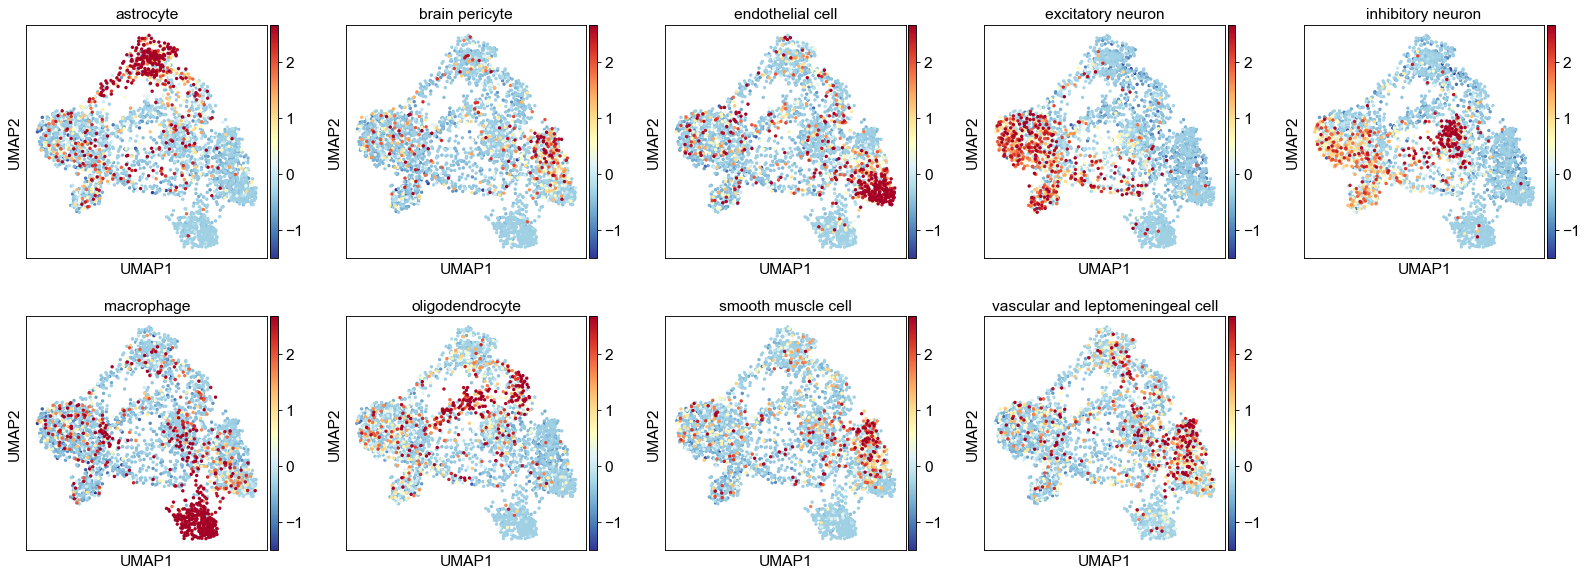

In [36]:
# In[]
''' ============ cell type gene-profiles on gene embeddings ============
'''
# averaged expressions
avg_expr1 = pp.group_mean_adata(adatas[0], groupby=key_class1,
                                features=dpair.vnode_names1, use_raw=True)
avg_expr2 = pp.group_mean_adata(adatas[1], groupby=key_class2,
                                features=dpair.vnode_names2, use_raw=True)
# adata_raw1.X.data

avg_expr_add1, avg_expr_add2 = list(map(
    lambda x: pp.zscore(x.T).T, (avg_expr1, avg_expr2)
))

# add annos
pp.add_obs_annos(gadt1, avg_expr_add1, ignore_index=True)
pp.add_obs_annos(gadt2, avg_expr_add2, ignore_index=True)

''' plot cell type gene-profiles (plot all the cell types) on UMAP '''
ctypes1 = avg_expr1.columns.tolist()
ctypes2 = avg_expr2.columns.tolist()
sc.set_figure_params(fontsize=14)
cmap_expr = 'RdYlBu_r'
vmax = None
vmin = - 1.5
plkwds = dict(color_map=cmap_expr, vmax=vmax, vmin=vmin, ncols=5, )
sc.pl.umap(gadt1, color=ctypes1,
           #           edges=True, size=50,
           save=f'_exprAvgs-{dsn1}-all.png', **plkwds)
sc.pl.umap(gadt2, color=ctypes2,
           #           edges=True, size=50,
           save=f'_exprAvgs-{dsn2}-all.png', **plkwds)

# gadt1.write(resdir / 'adt_hidden_gene1.h5ad')
# gadt2.write(resdir / 'adt_hidden_gene2.h5ad')


In [37]:
# In[]
''' gene annotation on UMAP (top DEGs)
'''
fdir_gmap = resdir / 'gene_umap'
came.check_dirs(fdir_gmap)

adata1.obs[key_class1] = pd.Categorical(obs[key_class1][obs_ids1],
                                        categories=classes)
adata2.obs['predicted'] = pd.Categorical(obs['predicted'][obs_ids2],
                                         categories=classes)
pp.add_obs_annos(adata2, obs[classes].iloc[obs_ids2], ignore_index=True)

df_top1 = pp.compute_and_get_DEGs(adata1, key_class1, unique=False, )
df_top2 = pp.compute_and_get_DEGs(adata2, 'predicted',
                                  unique=False, )  # line 749
for _adt, sp, _df_top in zip([gadt1, gadt2],
                             (sp1, sp2),
                             (df_top1, df_top2),
                             ):
    for c in _df_top.columns[: 2]:
        text_ids = _df_top[c].head(10)

        nm = _adt.obs['dataset'][0]
        ftps = ['pdf', 'svg', 'png']
        ftp = ftps[1]
        if c not in _adt.obs.columns:
            continue
        ax = pl.umap_with_annotates(_adt, color=c, text_ids=text_ids,
                                    #                                      edges=True, size=30,
                                    title=f'{sp} {c}',
                                    index_col='name',
                                    fp=fdir_gmap / f'hexpr-{c}-{nm}.{ftp}',
                                    **plkwds)
        ax.figure



NameError: name 'CAME' is not defined

In [39]:
# In[]
''' =================== abstracted graph ====================  '''
norm_ov = ['max', 'zs', None][1]
cut_ov = 0.  # 5#(0.5, 2.5)
# norm_ov = 'zs'
# cut_ov = (0.5, 2.5)
ovby = ['expr', 'attn'][0]
groupby_var = 'module'
obs_labels1, obs_labels2 = adt.obs['celltype'][dpair.obs_ids1], \
                           adt.obs['celltype'][dpair.obs_ids2]
var_labels1, var_labels2 = gadt1.obs[groupby_var], gadt2.obs[groupby_var]

sp1, sp2 = 'human', 'mouse'
g = came.make_abstracted_graph(
    obs_labels1, obs_labels2,
    var_labels1, var_labels2,
    avg_expr1, avg_expr2,
    df_var_links,
    tags_obs=(f'{sp1} ', f'{sp2} '),
    tags_var=(f'{sp1} module ', f'{sp2} module '),
    cut_ov=cut_ov,
    norm_mtd_ov=norm_ov,
)

''' visualization '''
fp_abs = figdir / f'abstracted_graph-{groupby_var}-cut{cut_ov}-{norm_ov}-{ovby}.pdf'
ax = pl.plot_multipartite_graph(
    g, edge_scale=10,
    figsize=(9, 7.5), alpha=0.5, fp=fp_abs)  # nodelist=nodelist,

ax.figure
# unlabeled
ax = pl.plot_multipartite_graph(
    g, edge_scale=10, figsize=(9, 7.5), alpha=0.5,
    xscale=1.25,
    fp=figdir / f'abstracted_graph-nolabels.pdf',
    with_labels=False)  # nodelist=nodelist,



3352 3173
---> ['0', '1', '2', '3', '4', '5', '6', '7', '8']
Edges with weights lower than 0 were cut out.
Edges with weights lower than 0 were cut out.
---> avg_vo1
                  Purkinje cell  astrocyte  brain pericyte  \
__temp_labels__                                             
0                     0.027073  -0.145324       -0.219351   
1                    -0.171436  -0.307564        1.025949   
2                     1.040450  -0.211281       -0.233797   
3                    -0.241523   1.865732        0.023345   
4                     0.384263  -0.102616       -0.259725   
5                    -0.172867  -0.332835       -0.211200   
6                    -0.383104  -0.225748       -0.156353   
7                     0.345103  -0.164513       -0.347937   
8                    -0.048325  -0.015476       -0.373483   

                 cerebellar granule cell  endothelial cell  excitatory neuron  \
__temp_labels__                                                                 

..\came\utils\plot.py:889: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodedf['plt_size'][inds_sub] *= size_scale
..\came\utils\plot.py:889: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodedf['plt_size'][inds_sub] *= size_scale
..\came\utils\plot.py:889: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodedf['plt_size'][inds_sub] *= size_scale
..\came\utils\plot.py:889: SettingWithCopyWarning: 
A value is trying to be set on a copy o

figure has been saved into:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\figs\abstracted_graph-module-cut0.0-zs-expr.pdf
[10, 9, 9, 9]
figure has been saved into:
	..\_temp\('Lake_2018', 'Tasic18')-(07-28 00.14.54)\figs\abstracted_graph-nolabels.pdf


..\came\utils\plot.py:889: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodedf['plt_size'][inds_sub] *= size_scale
..\came\utils\plot.py:889: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodedf['plt_size'][inds_sub] *= size_scale
..\came\utils\plot.py:889: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodedf['plt_size'][inds_sub] *= size_scale
..\came\utils\plot.py:889: SettingWithCopyWarning: 
A value is trying to be set on a copy o

### TF-target exploration

In [25]:
''' TF-target exploration '''


human_tf = pd.read_csv(f'E:/lxy_pro/004/resources/TF/fantomTFs-human.csv')['Symbol'].tolist()
mouse_tf = pd.read_csv(f'E:/lxy_pro/004/resources/TF/fantomTFs-mouse.csv')['Symbol'].tolist()
TFdict = {'mouse': mouse_tf,
          'human': human_tf,
          }
TFdict
# node-ids for TF
tfids1 = dpair.get_vnode_ids_by_name(human_tf, 0)
tfids2 = dpair.get_vnode_ids_by_name(mouse_tf, 1)

tfset1 = np.take(human_tf, np.flatnonzero(pd.notna(tfids1)))
tfset2 =  np.take(mouse_tf, np.flatnonzero(pd.notna(tfids2)))

len(tfset1), len(tfset2)

#  annotate TFs on gene UMAP 


(193, 178)

In [27]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, cdist
# from came.models._utils import get_hidden_states
ilayer = [0, -1][0]
metric = 'cosine'
k = 20
# get hidden states
h_dict = trainer.model.get_hidden_states(i_layer=ilayer)
h_dict



# TF-centered links --> graph

# TF-regulons --> sets


# target-set-intersection cross species


# TF-centered modules








{'cell': array([[-8.4645981e-03,  2.0489560e-01, -2.7153991e-02, ...,
          7.7366233e-01, -2.5325626e-02,  0.0000000e+00],
        [-1.9128703e-02, -1.8616552e-02, -7.8562638e-03, ...,
          0.0000000e+00,  0.0000000e+00,  4.0804121e-01],
        [ 0.0000000e+00, -2.2942405e-02, -2.3128891e-02, ...,
         -5.9527293e-02,  2.9792669e-01,  1.2151665e-01],
        ...,
        [ 0.0000000e+00, -5.8295294e-03, -1.4621479e-04, ...,
          0.0000000e+00,  0.0000000e+00,  3.2274202e-01],
        [ 0.0000000e+00, -3.0411687e-03, -1.2452361e-02, ...,
         -2.7454535e-02, -4.5322124e-02,  0.0000000e+00],
        [-2.5342733e-02,  0.0000000e+00, -1.7603673e-02, ...,
          0.0000000e+00, -1.5835627e-04, -6.3171313e-04]], dtype=float32),
 'gene': array([[-0.07047163, -0.01363296,  3.640357  , ...,  0.78507656,
         -0.01857928, -0.03711466],
        [ 0.        ,  0.00416389,  2.0819316 , ...,  0.31012717,
         -0.03013276,  0.        ],
        [ 0.        , -0.05562